# Busqueda features en titulo y descripcion

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
import time

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)

In [2]:
def remove_stopwords(text,stopwords):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stopwords] 
    filtered_sentence = []
    for w in word_tokens: 
        if w not in stopwords: 
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)

In [3]:
# stopwords son palabras que no nos interesan en nuestro analisis
from stop_words import get_stop_words

stop_words = get_stop_words('spanish')

stopwords = ["en", "a", "al", "de", "la", "y", "el", "del", "las", "los", "-","nbsp"]

stopwords.extend(stop_words)
stopwords.extend(STOPWORDS)

In [4]:
import re
import string
def clean_text_round(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[&;.*?¿\‘’“”…«»]\%;', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\x95', ' ', text)
    text = re.sub('acute', '', text)
    text = re.sub('tilde', '', text)
    text = re.sub(' p ', '', text)
    text = re.sub('nbsp', '', text)
    text = re.sub('á', 'a', text)
    text = re.sub('é', 'e', text)
    text = re.sub('í', 'i', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('ú', 'u', text)
    return text

def limpiar_texto(text):
    return remove_stopwords(clean_text_round(text),stopwords)

In [5]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

df = df.drop(columns=["lat","lng"])

In [6]:
start_time = time.time()
df["descripcion"] = df["descripcion"].fillna("").transform(lambda x: limpiar_texto(x))
print("--- %s seconds ---" % (time.time() - start_time))
df["titulo"] = df["titulo"].fillna("").transform(lambda x: limpiar_texto(x))
print("--- %s seconds ---" % (time.time() - start_time))
df["direccion"] = df["direccion"].fillna("").transform(lambda x: limpiar_texto(x))
print("--- %s seconds ---" % (time.time() - start_time))

--- 219.7163496017456 seconds ---
--- 259.66799545288086 seconds ---
--- 285.05381059646606 seconds ---


## Wordclouds

Para saber qué palabras pueden sernos de interes, hacemos wordclouds para guiarnos

In [7]:
def wordcloud_freq(data):
    text = data
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate_from_frequencies(frequencies=data)
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

### Wordcloud título

In [8]:
palabras_titulo = pd.Series([palabra.replace("\'", "") for titulos in df["titulo"] for palabra in titulos.split()])

In [9]:
dict_palabras_titulo = palabras_titulo.loc[~palabras_titulo.isin(stopwords)].groupby(palabras_titulo).size().to_dict()

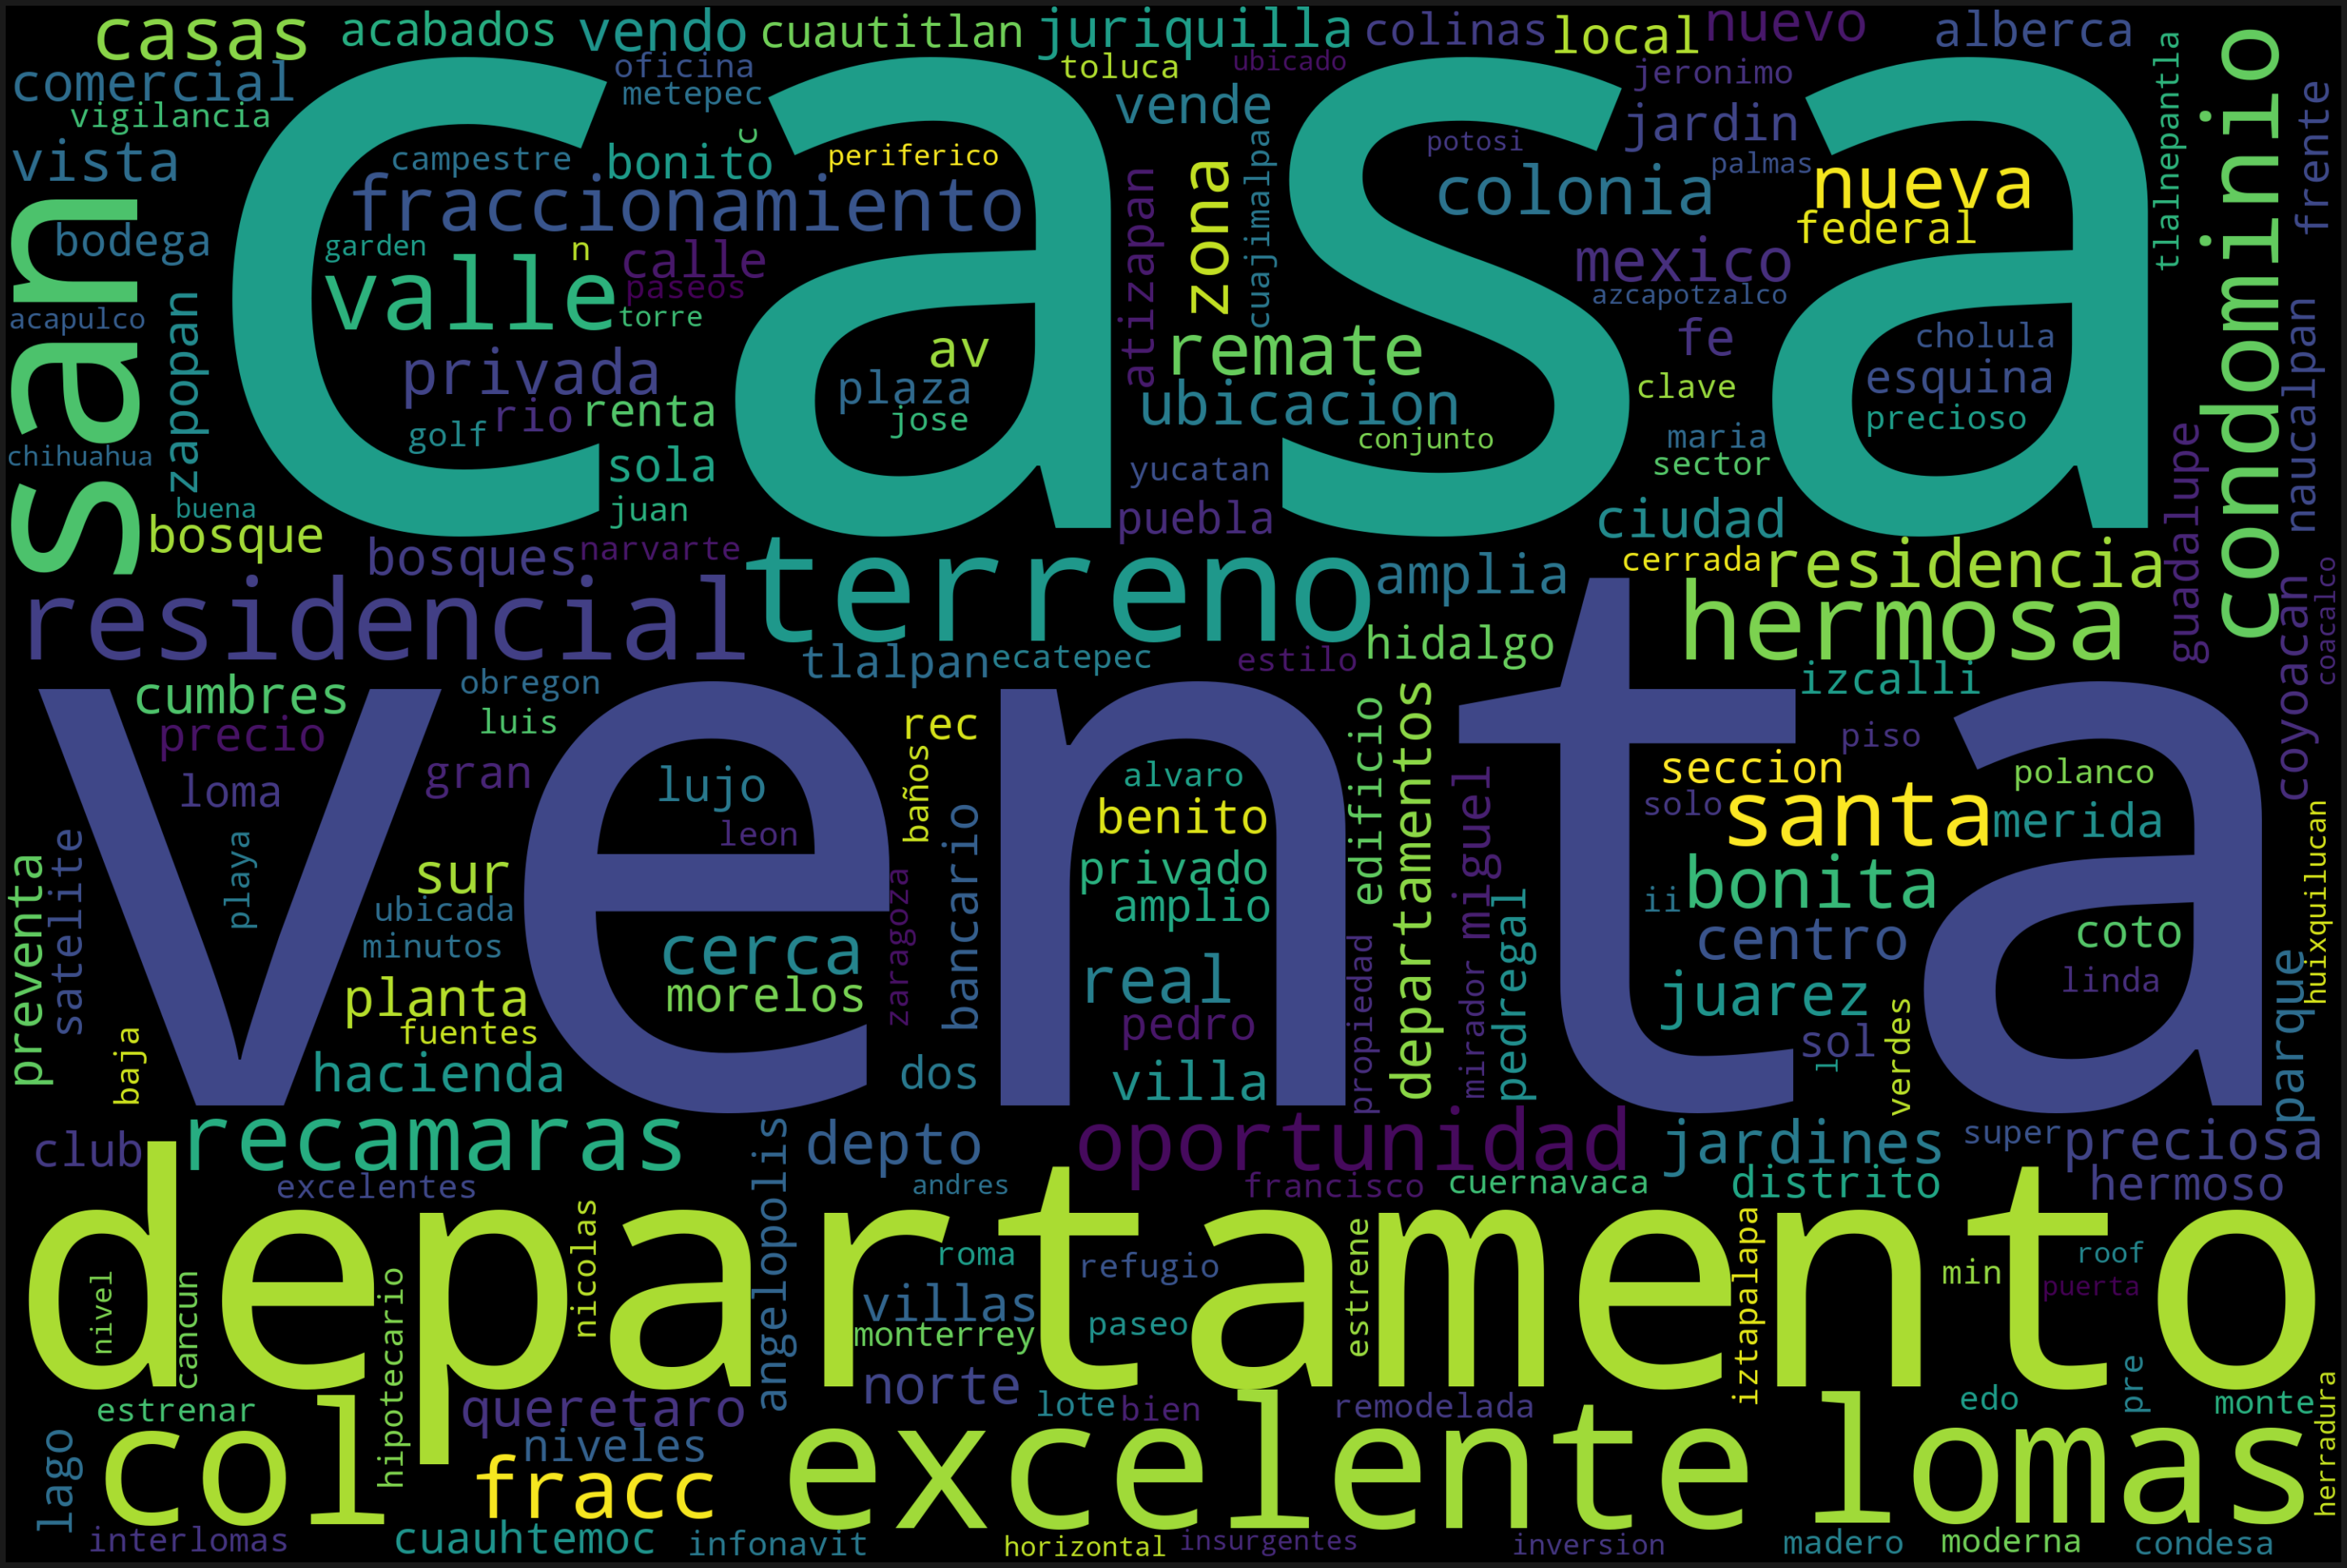

In [10]:
ax = wordcloud_freq(dict_palabras_titulo)
ax

### Wordcloud descripción

In [11]:
palabras_descripcion = pd.Series([palabra for descripcion in df["descripcion"] for palabra in descripcion.split()])

In [12]:
dict_palabras_descripcion = palabras_descripcion.loc[~palabras_descripcion.isin(stopwords)].groupby(palabras_descripcion).size().to_dict()

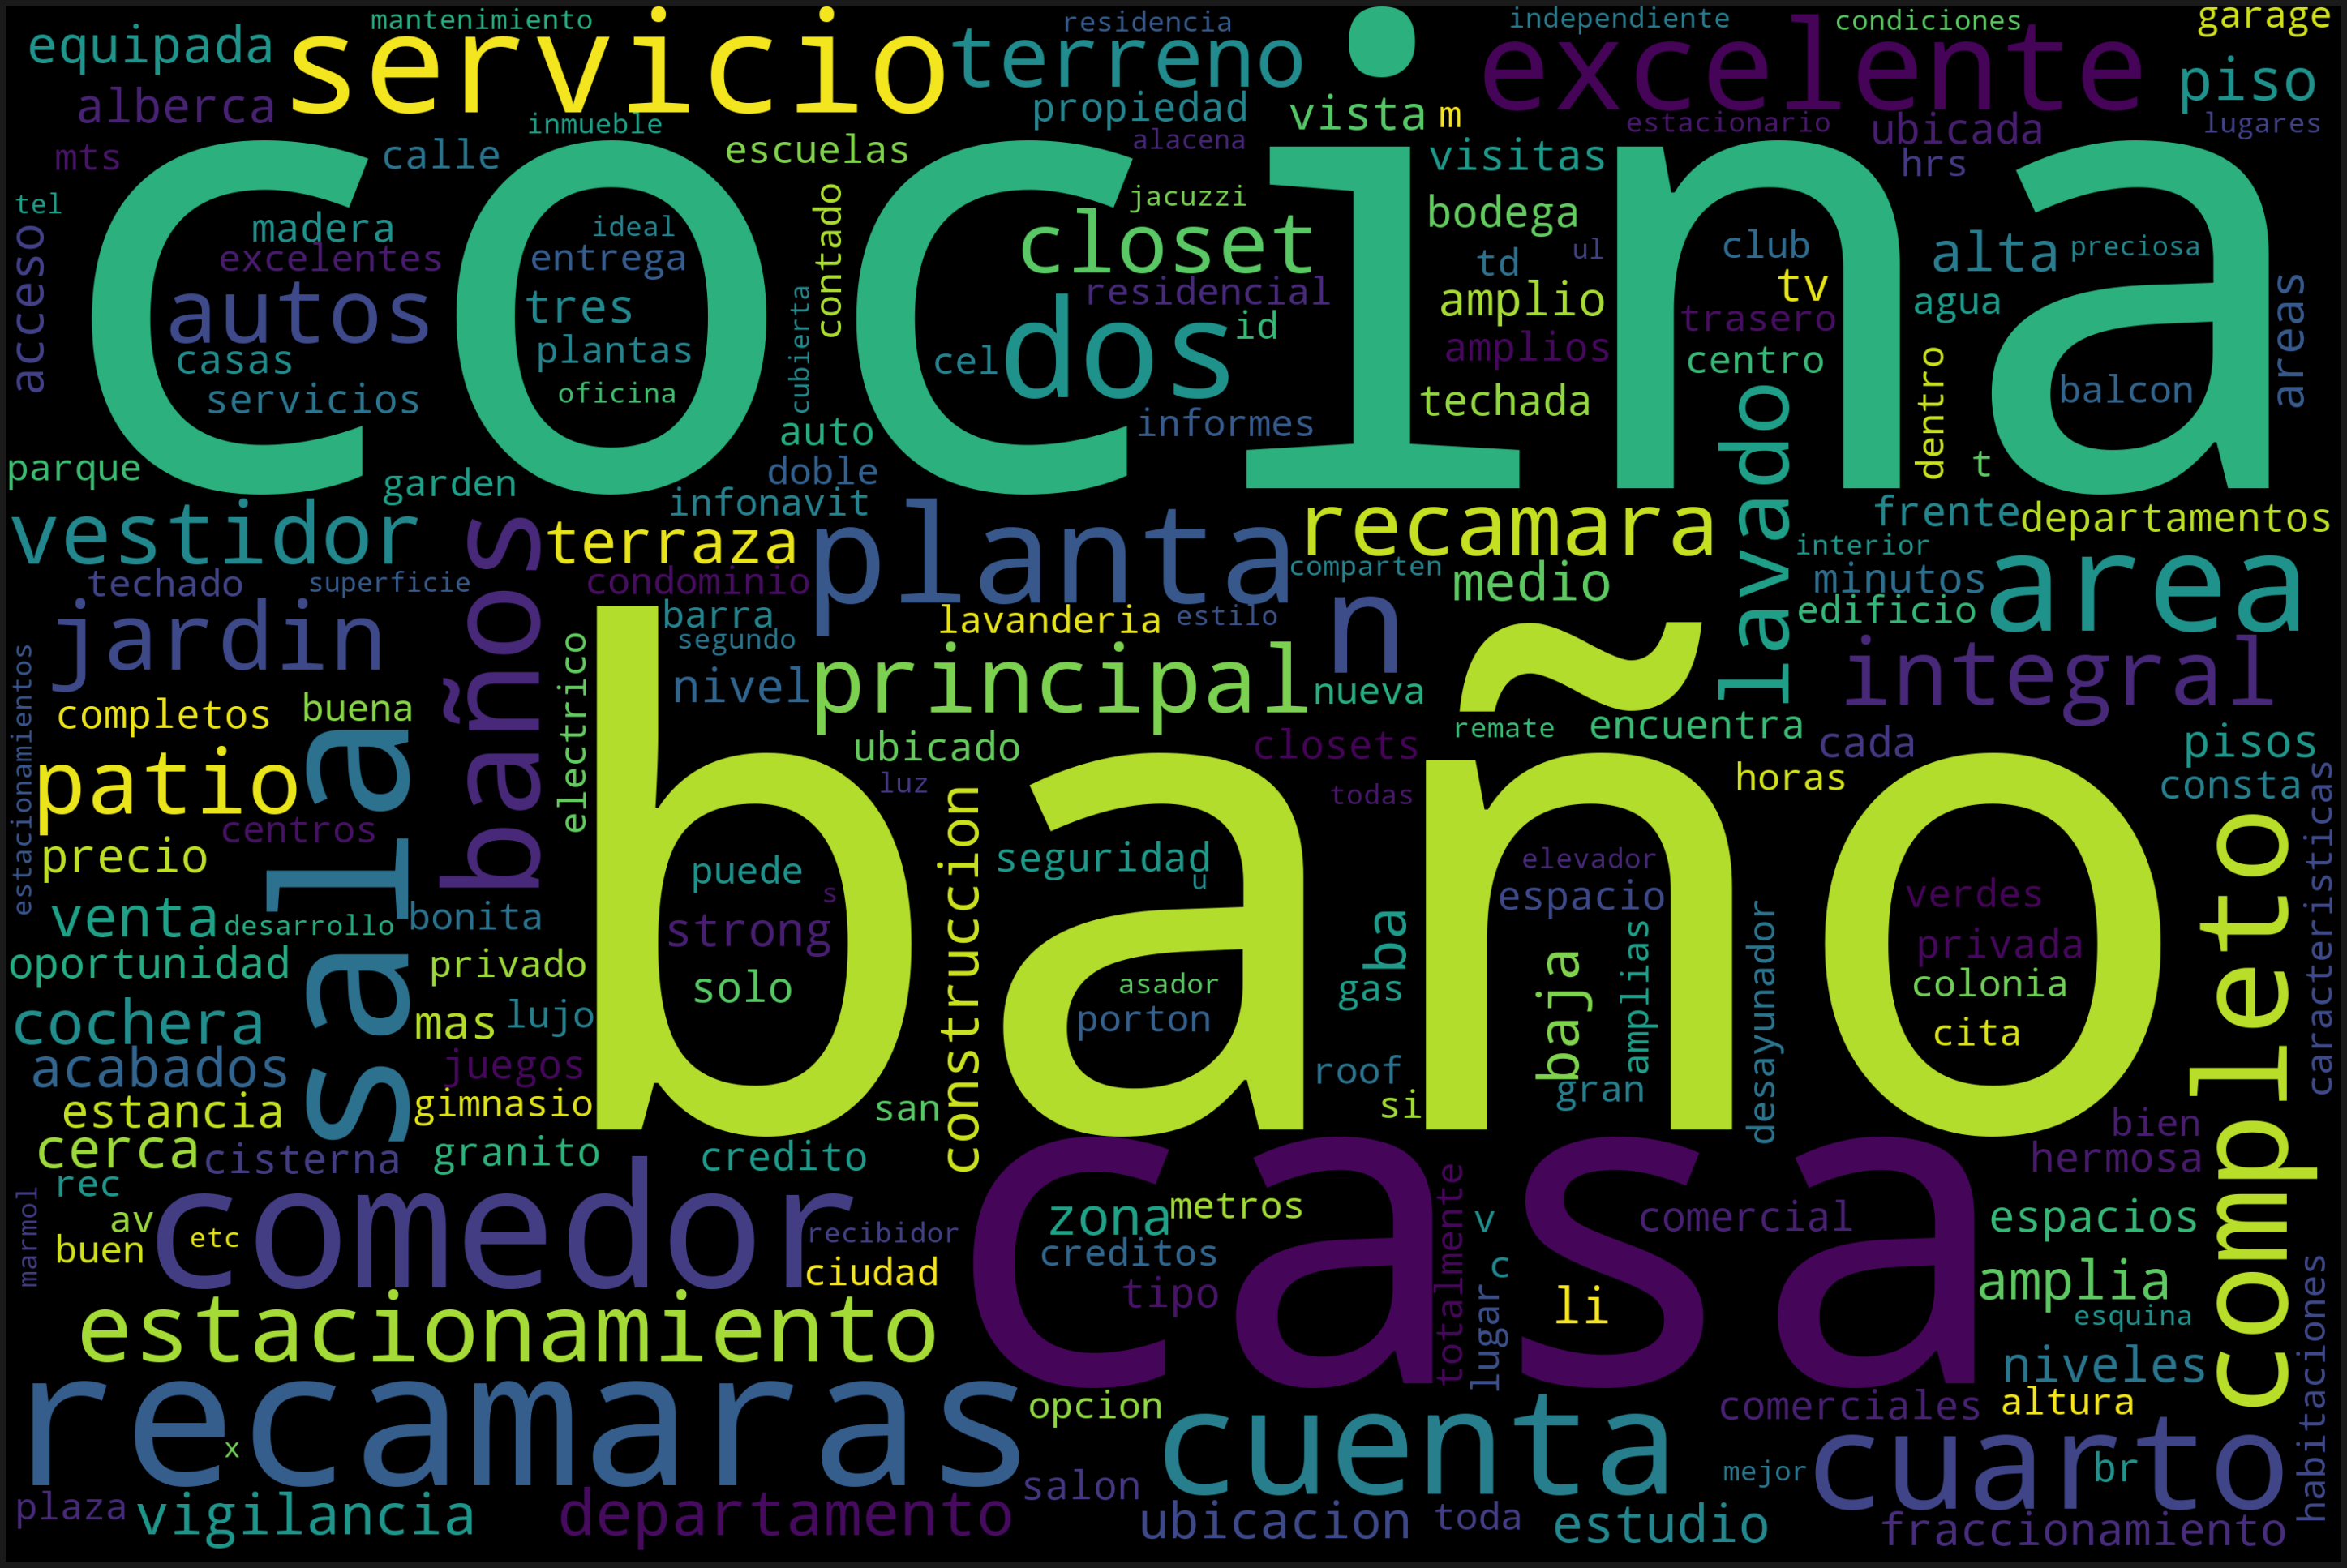

In [13]:
wordcloud_freq(dict_palabras_descripcion)

### Wordcloud direccion

In [14]:
palabras_descripcion = pd.Series([palabra for direccion in df["direccion"] for palabra in direccion.split()])

In [15]:
dict_palabras_descripcion = palabras_descripcion.loc[~palabras_descripcion.isin(stopwords)].groupby(palabras_descripcion).size().to_dict()

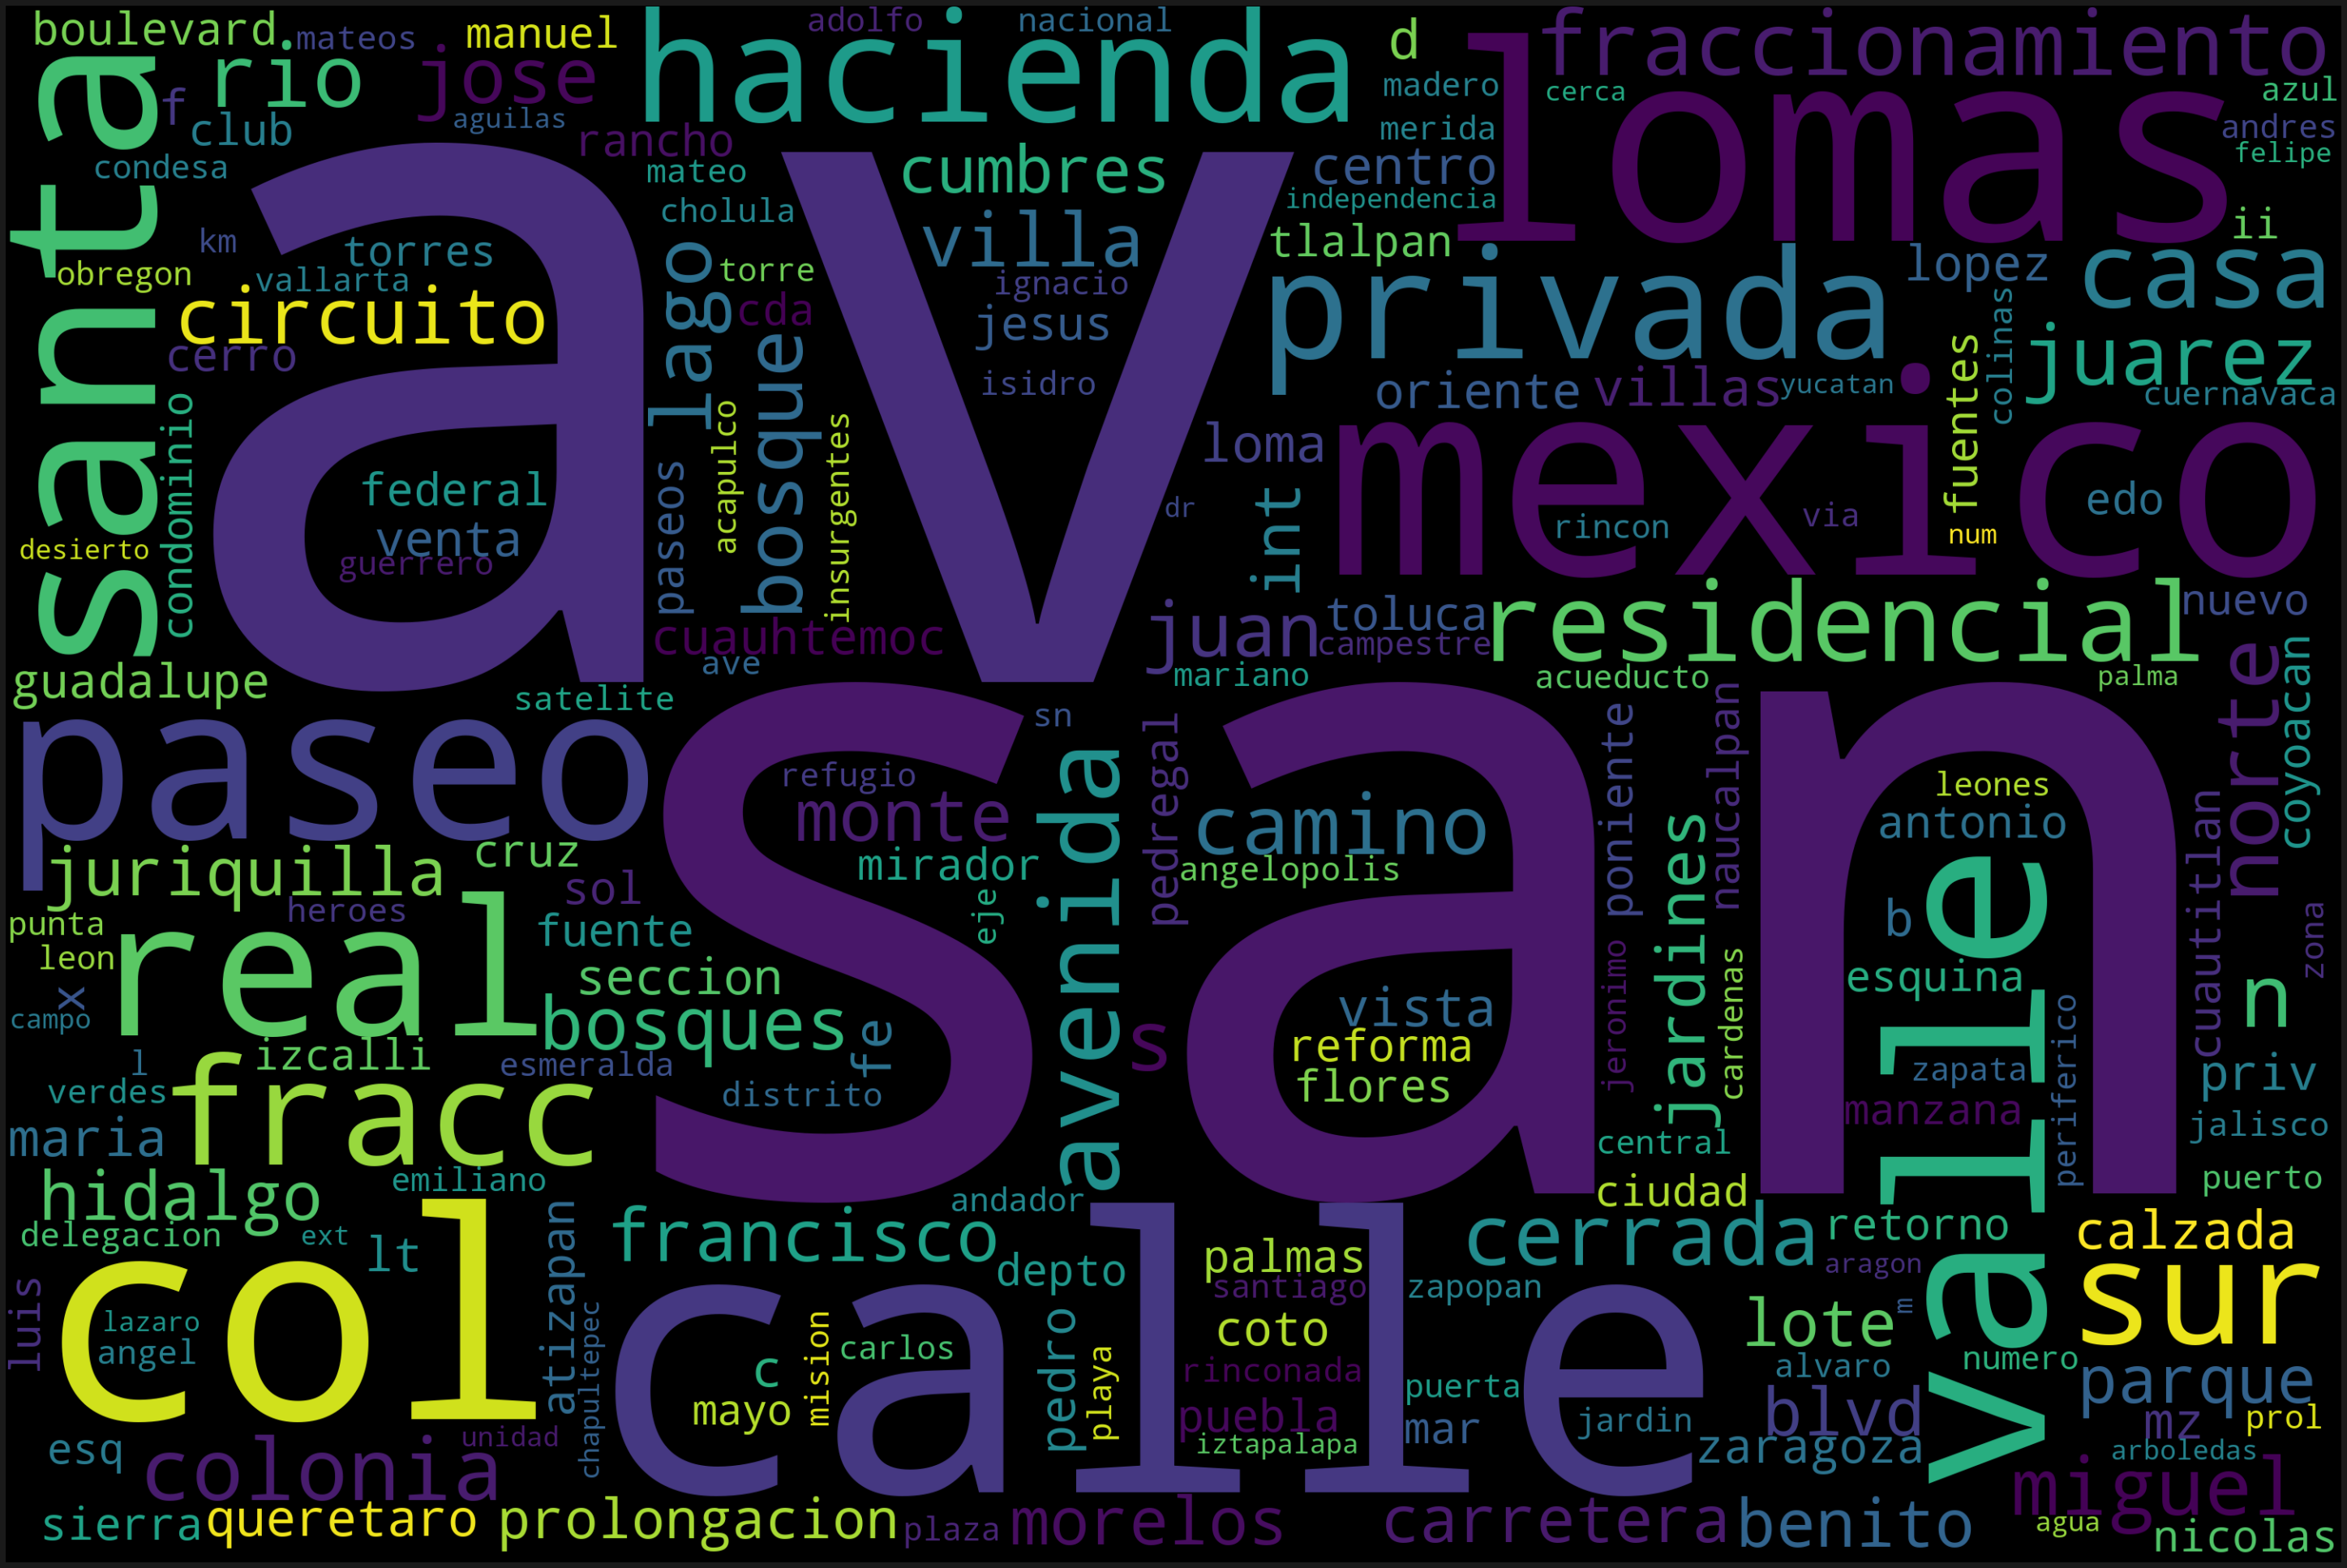

In [16]:
wordcloud_freq(dict_palabras_descripcion)

## Búsqueda palabras clave

In [17]:
def contiene(df, columna, palabra):
    return df[columna].str.contains(palabra).astype(int)

In [18]:
def contiene_alguna(df, columna, palabras):
    result = df[columna].apply(lambda x: 0)
    for palabra in palabras:
        result = result | contiene(df, columna, palabra)
        
    return result    

In [19]:
# del wordcloud
df["palabra_hermosa"] = contiene_alguna(df, "descripcion", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "preciosa", "precioso"]) | contiene_alguna(df, "titulo", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "precioso", "preciosa"])
df["palabra_excelente"] = contiene_alguna(df, "descripcion", ["excelente", "excelentes"]) | contiene_alguna(df, "titulo", ["excelente", "excelentes"])
df["palabra_mejor"] = contiene_alguna(df, "descripcion", ["mejor", "mejores"]) | contiene_alguna(df, "titulo", ["mejor", "mejores"])
df["palabra_grande"] = contiene_alguna(df, "descripcion", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"]) | contiene_alguna(df, "titulo", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"])
df["palabra_equipada"] = contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"]) | contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"])
df["palabra_vestidor"] = contiene_alguna(df, "descripcion", ["vestidor", "closet"]) | contiene_alguna(df, "titulo", ["vestidor", "closet"])
df["palabra_credito"] = contiene_alguna(df, "descripcion", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"]) | contiene_alguna(df, "titulo", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"])
df["palabra_privada"] = contiene_alguna(df, "descripcion", ["privada", "privado"]) | contiene_alguna(df, "titulo", ["privada", "privado"])
df["palabra_bodega"] = contiene_alguna(df, "descripcion", ["bodega"]) | contiene_alguna(df, "titulo", ["bodega"])
df["palabra_club"] = contiene_alguna(df, "descripcion", ["club"]) | contiene_alguna(df, "titulo", ["club"])
df["palabra_cerrada"] = contiene_alguna(df, "descripcion", ["cerrada", "cerrado"]) | contiene_alguna(df, "titulo", ["cerrada", "cerrado"])
df["palabra_jardin"] = contiene_alguna(df, "descripcion", ["jardin", "jardín", "garden", "patio"]) | contiene_alguna(df, "titulo", ["jardin", "jardín", "garden", "patio"])
df["palabra_oportunidad"] = contiene_alguna(df, "descripcion", ["oportunidad"]) | contiene_alguna(df, "titulo", ["oportunidad"])
df["palabra_tv"] = contiene_alguna(df, "descripcion", ["tv", "tele", "television", "televisión", "televisor"]) | contiene_alguna(df, "titulo", ["tv", "tele", "television", "televisión", "televisor"])
df["palabra_juegos"] = contiene_alguna(df, "descripcion", ["juego"]) | contiene_alguna(df, "titulo", ["juego"])
df["palabra_niño"] = contiene_alguna(df, "descripcion", ["niño", "niña", "infantil"]) | contiene_alguna(df, "titulo", ["niño", "niña", "infantil"])
df["palabra_transporte"] = contiene_alguna(df, "descripcion", ["transporte"]) | contiene_alguna(df, "titulo", ["transporte"])
df["palabra_estudio"] = contiene_alguna(df, "descripcion", ["estudio"]) | contiene_alguna(df, "titulo", ["estudio"])
df["palabra_terraza"] = contiene_alguna(df, "descripcion", ["terraza"]) | contiene_alguna(df, "titulo", ["terraza"])
df["palabra_balcon"] = contiene_alguna(df, "descripcion", ["balcón", "balcon"]) | contiene_alguna(df, "titulo", ["balcón", "balcon"])
df["palabra_lote"] = contiene_alguna(df, "descripcion", ["lote", "terreno"]) | contiene_alguna(df, "titulo", ["lote", "terreno"])
df["palabra_fraccionamiento"] = contiene_alguna(df, "descripcion", ["fraccionamiento", "fracc"]) | contiene_alguna(df, "titulo", ["fraccionamiento", "fracc"])
df["palabra_local"] = contiene_alguna(df, "descripcion", ["local", "tienda", "comercial"]) | contiene_alguna(df, "titulo", ["local", "tienda", "comercial"])
df["palabra_seguridad"] = contiene_alguna(df, "descripcion", ["vigilancia", "vigilador", "seguridad", "guardia"]) | contiene_alguna(df, "titulo", ["vigilancia", "vigilador", "seguridad", "guardia"])
df["palabra_garage"] = contiene_alguna(df, "descripcion", ["garage", "auto", "estacionamiento"]) | contiene_alguna(df, "titulo", ["garage", "auto", "estacionamiento"])
df["palabra_centro"] = contiene_alguna(df, "descripcion", ["centro", "central", "cercano", "cercania", "minuto"]) | contiene_alguna(df, "titulo", ["centro", "central", "cercano", "cercania", "minuto"])
df["palabra_techada"] = contiene_alguna(df, "descripcion", ["techada", "techado", "roof"]) | contiene_alguna(df, "titulo", ["techada", "techado", "roof"])
df["palabra_estancia"] = contiene_alguna(df, "descripcion", ["estancia"]) | contiene_alguna(df, "titulo", ["estancia"])
df["palabra_alberca"] = contiene_alguna(df, "descripcion", ["alberca"]) | contiene_alguna(df, "titulo", ["alberca"])
df["palabra_servicios"] = contiene_alguna(df, "descripcion", ["servicios"]) | contiene_alguna(df, "titulo", ["servicios"])
df["palabra_servicio"] = contiene_alguna(df, "descripcion", ["servicio"]) | contiene_alguna(df, "titulo", ["servicio"])
df["palabra_estilo"] = contiene_alguna(df, "descripcion", ["estilo"]) | contiene_alguna(df, "titulo", ["estilo"])
df["palabra_frente"] = contiene_alguna(df, "descripcion", ["frente"]) | contiene_alguna(df, "titulo", ["frente"])
df["palabra_vista"] = contiene_alguna(df, "descripcion", ["vista"]) | contiene_alguna(df, "titulo", ["vista"])
df["palabra_visitas"] = contiene_alguna(df, "descripcion", ["visita"]) | contiene_alguna(df, "titulo", ["visita"])
df["palabra_parque"] = contiene_alguna(df, "descripcion", ["parque", "plaza", "verde"]) | contiene_alguna(df, "titulo", ["parque", "plaza", "verde"])
df["palabra_areas"] = contiene_alguna(df, "descripcion", ["area", "área"]) | contiene_alguna(df, "titulo", ["area", "área"])
df["palabra_estrenar"] = contiene_alguna(df, "descripcion", ["estrenar", "estreno", "estrene"]) | contiene_alguna(df, "titulo", ["estrenar", "estreno", "estrene"])
df["palabra_infonavit"] = contiene_alguna(df, "descripcion", ["infonavit"]) | contiene_alguna(df, "titulo", ["infonavit"])
df["palabra_residencial"] = contiene_alguna(df, "descripcion", ["residencia"]) | contiene_alguna(df, "titulo", ["residencia"])
df["palabra_escuela"] = contiene_alguna(df, "descripcion", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"]) | contiene_alguna(df, "titulo", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"])
df["palabra_exclusivo"] = contiene_alguna(df, "descripcion", ["exclusivo", "exclusividad"]) | contiene_alguna(df, "titulo", ["exclusivo", "exclusividad"])
df["palabra_lujo"] = contiene_alguna(df, "descripcion", ["lujo"]) | contiene_alguna(df, "titulo", ["lujo"])
df["palabra_esquina"] = contiene_alguna(df, "descripcion", ["esquina"]) | contiene_alguna(df, "titulo", ["esquina"])
df["palabra_refaccion"] = contiene_alguna(df, "descripcion", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"]) | contiene_alguna(df, "titulo", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"])
df["palabra_country"] = contiene_alguna(df, "descripcion", ["country"]) | contiene_alguna(df, "titulo", ["country"])
df["palabra_barra"] = contiene_alguna(df, "descripcion", ["barra"]) | contiene_alguna(df, "titulo", ["barra"])
df["palabra_lavado"] = contiene_alguna(df, "descripcion", ["lavado"]) | contiene_alguna(df, "titulo", ["lavado"])
df["palabra_renta"] = contiene_alguna(df, "descripcion", ["renta", "alquiler", "alquilar"]) | contiene_alguna(df, "titulo", ["renta", "alquiler", "alquilar"])
df["palabra_super"] = contiene_alguna(df, "descripcion", ["super"]) | contiene_alguna(df, "titulo", ["super"])
df["palabra_lago"] = contiene_alguna(df, "descripcion", ["lago"]) | contiene_alguna(df, "titulo", ["lago"])
df["palabra_bosque"] = contiene_alguna(df, "descripcion", ["bosque", "arbol", "árbol"]) | contiene_alguna(df, "titulo", ["bosque", "arbol", "árbol"])
df["palabra_avenida"] = contiene_alguna(df, "descripcion", ["av", "avenida"]) | contiene_alguna(df, "titulo", ["av", "avenida"])
df["palabra_hospital"] = contiene_alguna(df, "descripcion", ["hospital", "medicina", "medico", "médico", "farmacia"]) | contiene_alguna(df, "titulo", ["hospital", "medicina", "medico", "médico", "farmacia"])
df["palabra_pileta"] = contiene_alguna(df, "descripcion", ["pileta", "piscina", "jacuzzi"]) | contiene_alguna(df, "titulo", ["pileta", "piscina", "jacuzzi"])
df["palabra_solarium"] = contiene_alguna(df, "descripcion", ["solarium"]) | contiene_alguna(df, "titulo", ["solarium"])
df["palabra_gas"] = contiene_alguna(df, "descripcion", ["gas", "estufa"]) | contiene_alguna(df, "titulo", ["gas", "estufa"])

#Direcciones
df["direc_privada"] = contiene_alguna(df, "direccion", ["privada","priv","privado"]) 
df["direc_av"] = contiene_alguna(df, "direccion", ["av", "avenida"]) 
df["direc_camino"] = contiene_alguna(df, "direccion", ["playa"]) 
df["direc_playa"] = contiene_alguna(df, "direccion", ["camino"]) 


In [ ]:
df.to_csv("../data/palabras.csv", index=False)

In [37]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [42]:
tsnescatterplot(word2vec, 'depto', [i[0] for i in word2vec.wv.most_similar(negative=["depto"])])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 300 and the array at index 1 has size 100